# Using ML models Predicting Volatility
- Afet Ibadova 453818
- Daryush Ray 455894

## Introduction
**The aim of the Project** - (this part need to be added)

In [50]:
#!pip install yfinance
#!pip install ta
#pip install keras
#pip install tensorflow


#tf.disable_v2_behavior() # for tensorflow 1.x

## Import libraries and data

In [51]:
# Import libraries
import pandas as pd
import os

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import sklearn.preprocessing
from matplotlib import cycler
import seaborn as sns
import ta
from sklearn.preprocessing import MinMaxScaler
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

# For time stamps
from datetime import datetime

#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


In [52]:
# import data SP500
df = yf.download("SP")
df.columns

[*********************100%%**********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

## Investigate data

In [53]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4937.000000,4937.000000,4937.000000,4937.000000,4937.000000,4.937000e+03
mean,23.778478,24.132849,23.404164,23.771357,23.771357,7.828593e+04
std,9.337403,9.422153,9.250456,9.326899,9.326899,1.164835e+05
min,5.975000,6.075000,5.930000,5.990000,5.990000,0.000000e+00
25%,17.320000,17.629999,17.000000,17.330000,17.330000,3.370000e+04
50%,22.150000,22.490000,21.740000,22.190001,22.190001,5.600000e+04
75%,31.190001,31.639999,30.650000,31.190001,31.190001,9.250000e+04
max,52.290001,52.400002,51.500000,51.700001,51.700001,4.820400e+06


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4937 entries, 2004-06-02 to 2024-01-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4937 non-null   float64
 1   High       4937 non-null   float64
 2   Low        4937 non-null   float64
 3   Close      4937 non-null   float64
 4   Adj Close  4937 non-null   float64
 5   Volume     4937 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 270.0 KB


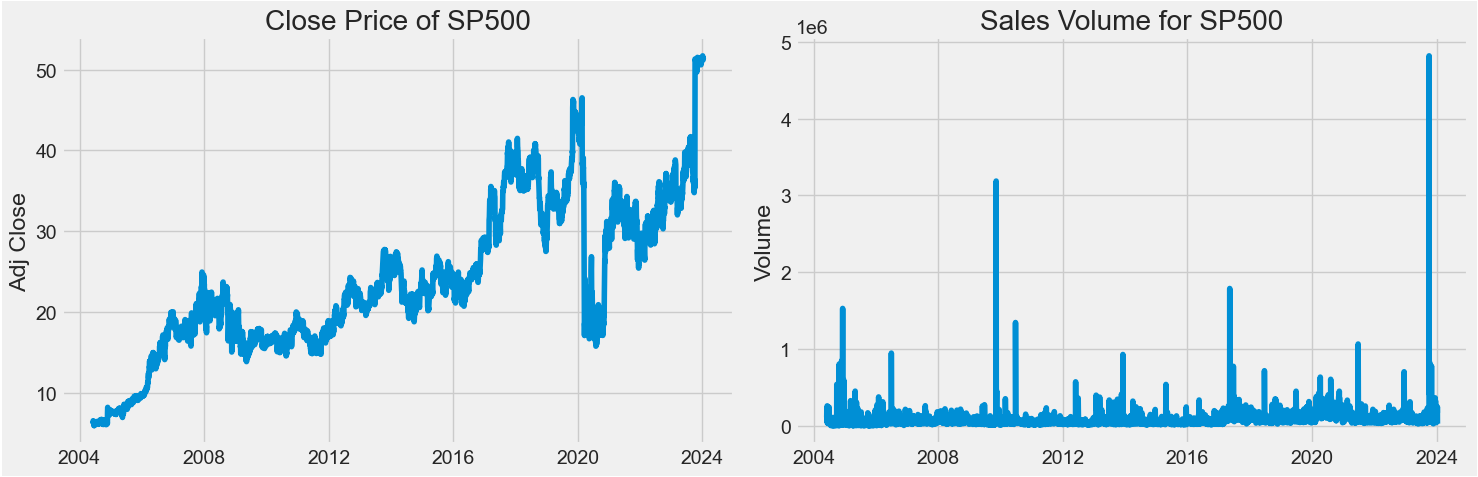

In [55]:
# Create a 1x2 subplot grid (one row, two columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5), linewidth=1)

# Plot the first subplot (Closing Price - Adj Close)
axs[0].plot(df.index, df['Adj Close'])
axs[0].set_ylabel('Adj Close')
axs[0].set_xlabel(None)
axs[0].set_title('Close Price of SP500')

# Plot the second subplot (Volume)
axs[1].plot(df.index, df['Volume'])
axs[1].set_ylabel('Volume')
axs[1].set_xlabel(None)
axs[1].set_title("Sales Volume for SP500")

# Adjust the layout
plt.tight_layout()

# Show the combined plot
plt.show()


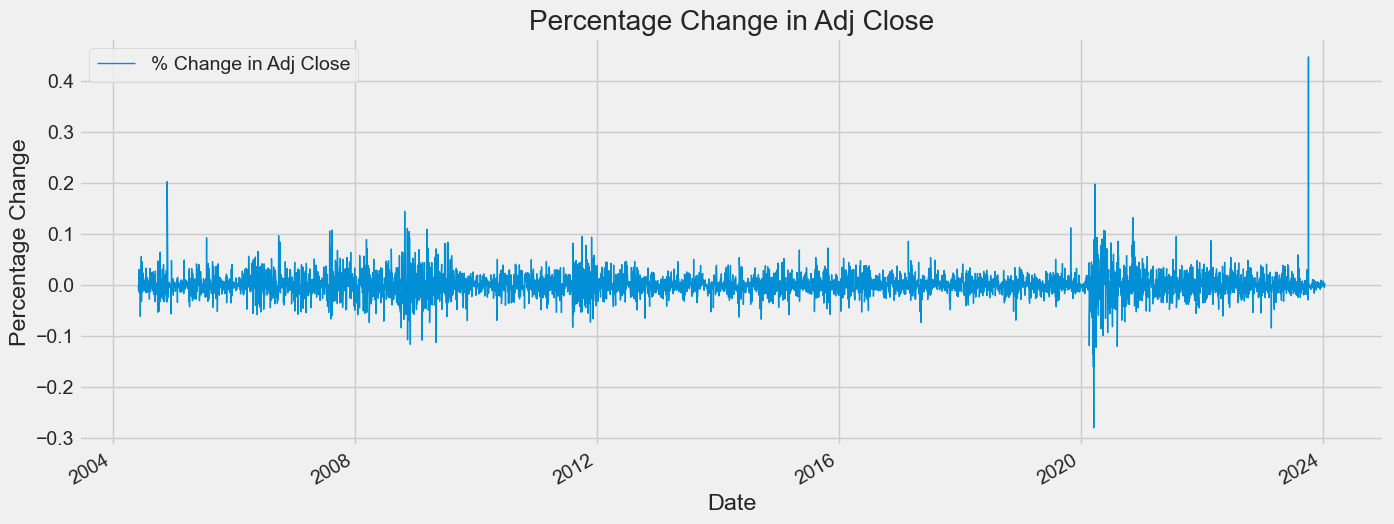

In [56]:
def plot_percentage_change_adj_close(df):
    df["Adj Close"].pct_change().plot(figsize=(15, 6),linewidth=1)
    plt.xlabel('Date')
    plt.ylabel('Percentage Change')
    plt.title('Percentage Change in Adj Close')
    plt.legend(['% Change in Adj Close'])
    plt.show()


plot_percentage_change_adj_close(df)


Let's get an overall look at the average daily return using a histogram.

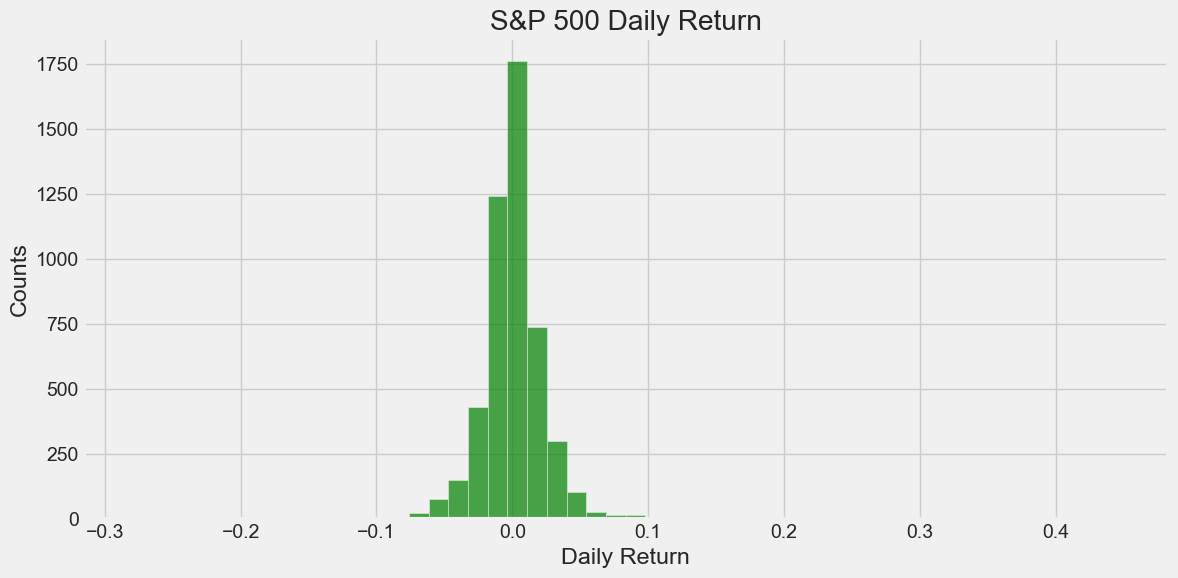

In [57]:
plt.figure(figsize=(12, 6))
df["Adj Close"].pct_change().hist(bins=50, color='green', alpha=0.7)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('S&P 500 Daily Return')
plt.tight_layout()
plt.show()

## Feature Engineering

**A Simple Moving Average (SMA)** is a technical indicator that calculates the average of a selected range of prices, typically closing prices, over a specified number of periods. It smooths out price data by filtering out the noise from random short-term fluctuations. The SMA is used in technical analysis to identify trends and potential reversals in a market.

**Moving Standard Deviation (MSD)** is a statistical measure that quantifies the variability or dispersion of a set of data points within a moving window over time. In financial markets, it's used to assess the volatility of an asset's price by calculating the standard deviation of the prices within a given time frame, which moves forward with each new period. This indicator helps traders understand the magnitude of price fluctuations and can be used to identify periods of high risk or potential trading opportunities.

**The relative strength index (RSI)** is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.



In [58]:
def feature_engineering(df):
    """ Create new variables"""

    # copy the dataframe to avoid interferences in the data
    df_copy = df.copy()
    df_copy = df_copy.fillna(method='ffill')

    # Create the returns
    df_copy["returns"] = df_copy["Close"].pct_change(1)

    # Create the SMAs
    df_copy["SMA 15"] = df_copy[["Close"]].rolling(15).mean().shift(1)
    df_copy["SMA 60"] = df_copy[["Close"]].rolling(60).mean().shift(1)

    # Create the volatilities
    df_copy["MSD 10"] = df_copy[["returns"]].rolling(10).std().shift(1)
    df_copy["MSD 30"] = df_copy[["returns"]].rolling(30).std().shift(1)

    # Create the Rsi
    RSI = ta.momentum.RSIIndicator(df_copy["Close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()

    return df_copy.dropna()

In [59]:
dfc.head(20)

,Open,High,Low,Close,Adj Close,Volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,,,,,,
2004-11-22,6.145,6.400,6.145,6.250,6.250,15200,-0.033256,6.311000,6.452250,0.020502,0.023522,46.906464
2004-11-23,6.260,6.275,6.230,6.250,6.250,29000,0.000000,6.310333,6.446417,0.020878,0.023436,46.906464
2004-11-24,6.480,7.980,6.480,7.515,7.515,847400,0.202400,6.293000,6.440583,0.019696,0.023383,71.747934
2004-11-26,7.745,8.710,7.690,8.250,8.250,155600,0.097804,6.374000,6.457083,0.066491,0.042361,78.145994
2004-11-29,8.240,8.275,8.020,8.050,8.050,207000,-0.024242,6.497000,6.483000,0.070675,0.045033,73.282743
2004-11-30,8.025,8.045,7.875,7.980,7.980,19800,-0.008696,6.605333,6.505333,0.072687,0.045429,71.603142
2004-12-01,7.980,8.070,7.980,8.000,8.000,20200,0.002506,6.722333,6.528500,0.072090,0.045467,71.801998
2004-12-02,7.850,8.000,7.850,7.985,7.985,8200,-0.001875,6.848667,6.553500,0.071440,0.045075,71.398169
2004-12-03,7.995,8.000,7.915,7.995,7.995,9600,0.001252,6.967333,6.576167,0.071217,0.044970,71.513193


In [60]:
dfc = feature_engineering(dfc)
dfc

C:\Users\DR455894\AppData\Local\Temp\ipykernel_6516\2817889046.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_copy = df_copy.fillna(method='ffill')


,Open,High,Low,Close,Adj Close,Volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,,,,,,
2005-02-17,7.450000,7.500000,7.050000,7.470000,7.470000,62200,-0.013861,7.575000,7.697417,0.006779,0.008962,41.820953
2005-02-18,7.475000,7.500000,7.360000,7.425000,7.425000,47000,-0.006024,7.567000,7.717750,0.007908,0.009283,39.315785
2005-02-22,7.490000,7.500000,7.430000,7.430000,7.430000,6600,0.000673,7.552333,7.737333,0.007904,0.009326,39.747634
2005-02-23,7.570000,7.570000,7.430000,7.450000,7.450000,5000,0.002692,7.539333,7.735917,0.007752,0.009270,41.539854
2005-02-24,7.375000,7.500000,7.375000,7.500000,7.500000,29200,0.006711,7.527667,7.722583,0.007655,0.009297,45.874430
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,51.509998,52.000000,51.500000,51.590000,51.590000,150000,-0.000194,51.207999,50.887167,0.003769,0.004200,60.696636
2024-01-08,51.580002,51.840000,51.349998,51.360001,51.360001,221800,-0.004458,51.230666,50.893000,0.003572,0.004203,55.338008
2024-01-09,51.240002,51.500000,51.110001,51.209999,51.209999,167200,-0.002921,51.254000,50.895000,0.003652,0.004222,52.106997


In [61]:
dfc.info

<bound method DataFrame.info of                  Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
2005-02-17   7.450000   7.500000   7.050000   7.470000   7.470000   62200   
2005-02-18   7.475000   7.500000   7.360000   7.425000   7.425000   47000   
2005-02-22   7.490000   7.500000   7.430000   7.430000   7.430000    6600   
2005-02-23   7.570000   7.570000   7.430000   7.450000   7.450000    5000   
2005-02-24   7.375000   7.500000   7.375000   7.500000   7.500000   29200   
...               ...        ...        ...        ...        ...     ...   
2024-01-05  51.509998  52.000000  51.500000  51.590000  51.590000  150000   
2024-01-08  51.580002  51.840000  51.349998  51.360001  51.360001  221800   
2024-01-09  51.240002  51.500000  51.110001  51.209999  51.209999  167200   
2024-01-10  51.220001  51.500000  51.220001  51.400002  51.400002  244800   
2024-01-11  51.400002  51.494999  51.250000 

In [62]:
dfc.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
returns      0
SMA 15       0
SMA 60       0
MSD 10       0
MSD 30       0
rsi          0
dtype: int64

<Axes: xlabel='Date'>

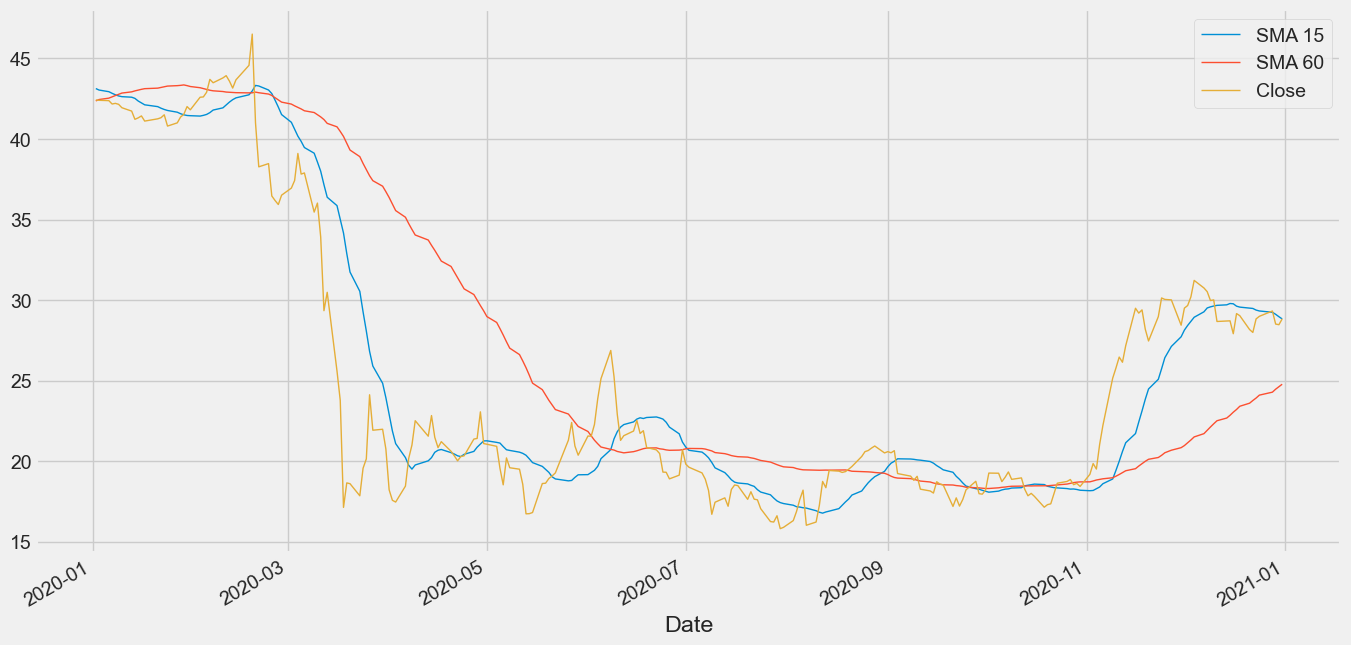

In [63]:
dfc[["SMA 15", "SMA 60", "Close"]].loc["2020"].plot(figsize=(15,8), linewidth=1)

<Axes: xlabel='Date'>

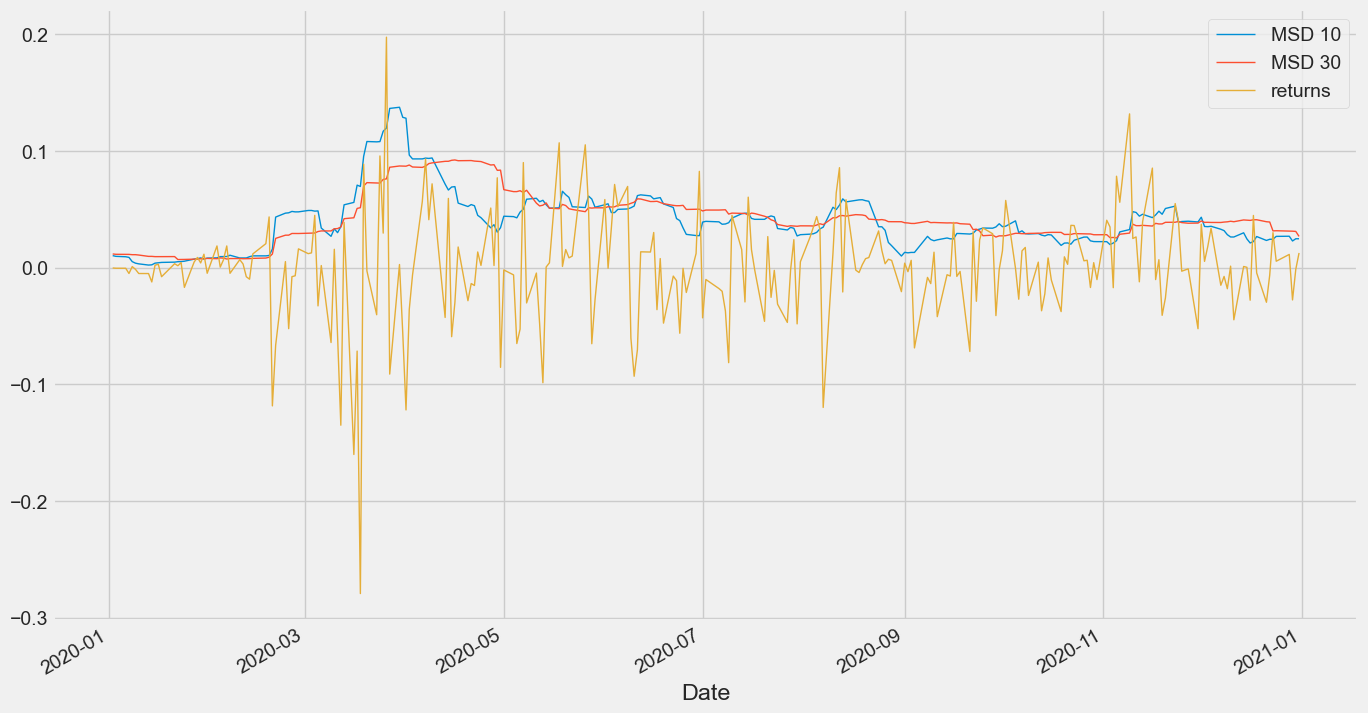

In [64]:
dfc[["MSD 10", "MSD 30", "returns"]].loc["2020"].plot(figsize=(15,9), linewidth=1)

<Axes: xlabel='Date'>

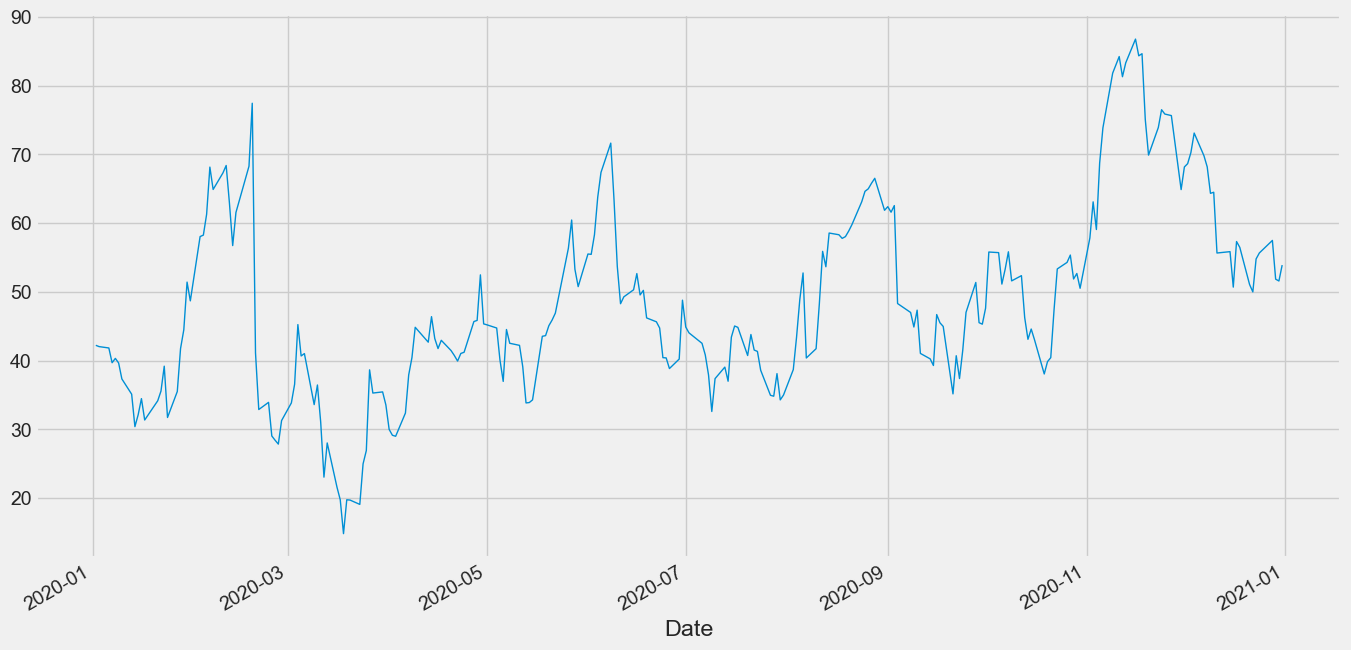

In [65]:
dfc["rsi"].loc["2020"].plot(figsize=(15,8), linewidth=1)

## Predicting stock price

### LSTM

In [66]:
# Create a new dataframe with only the 'Close column
data = dfc.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

3806

In [67]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01051454],
       [0.00950783],
       [0.00961968],
       ...,
       [0.98903799],
       [0.99328861],
       [0.99049219]])

In [68]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.01051454, 0.00950783, 0.00961968, 0.01006711, 0.01118568,
       0.01118568, 0.01118568, 0.00906041, 0.01085011, 0.01096196,
       0.00816554, 0.01621924, 0.0147651 , 0.01677852, 0.01767338,
       0.01923938, 0.0178971 , 0.0181208 , 0.0178971 , 0.01957494,
       0.0189038 , 0.01901566, 0.01856823, 0.0181208 , 0.01767338,
       0.01868009, 0.01744967, 0.01823266, 0.01935122, 0.01957494,
       0.02002237, 0.02505593, 0.01901566, 0.02472035, 0.01700224,
       0.01923938, 0.01923938, 0.02002237, 0.02125279, 0.0222595 ,
       0.02237136, 0.02058166, 0.01677852, 0.02237136, 0.02628636,
       0.02449665, 0.0189038 , 0.02293064, 0.02259508, 0.0204698 ,
       0.02237136, 0.01823266, 0.01588367, 0.01118568, 0.01006711,
       0.01208054, 0.00894855, 0.00894855, 0.00727069, 0.00615213])]
[0.005592841067852378]

[array([0.01051454, 0.00950783, 0.00961968, 0.01006711, 0.01118568,
       0.01118568, 0.01118568, 0.00906041, 0.01085011, 0.01096196,
       0.00816554, 0.01621924, 0.0

In [69]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

3746/3746 [==============================] - 57s 14ms/step - loss: 0.0010


In [70]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

30/30 [==============================] - 1s 16ms/step


1.0201794370875719

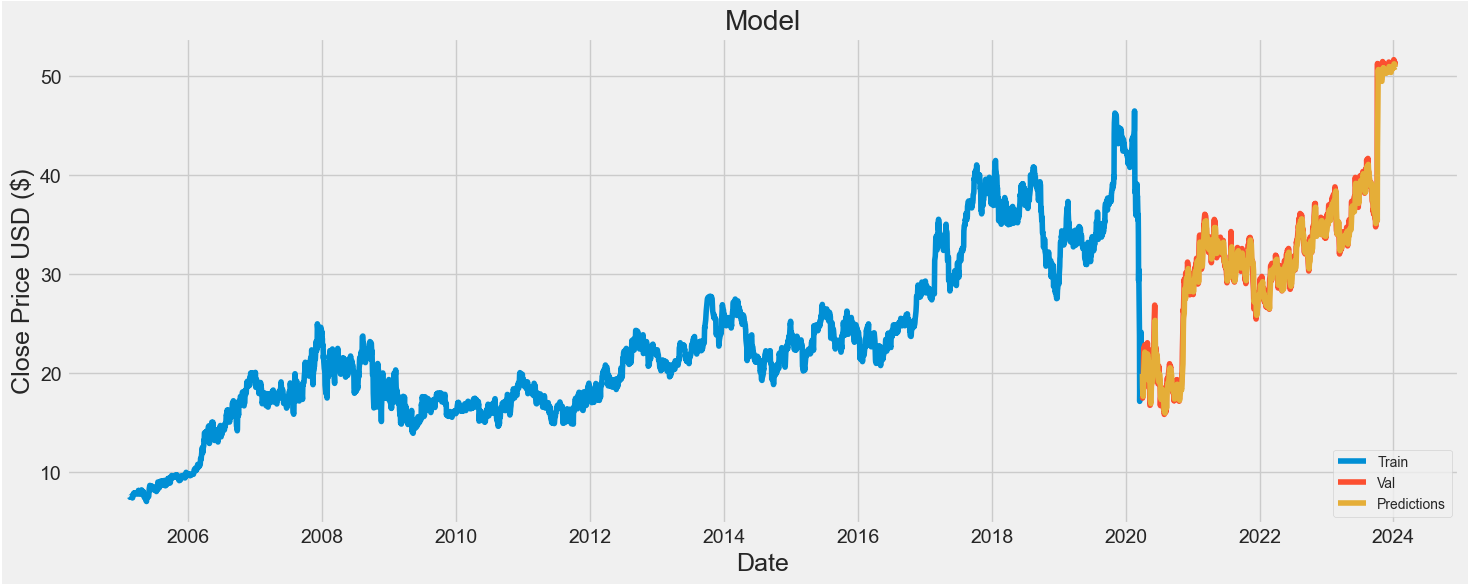

In [71]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid = valid.copy()
valid['Predictions'] = predictions

valid.loc[:, 'Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6), linewidth=1)
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right', fontsize=10)
plt.show()

In [105]:
dfc.head(15)

,Open,High,Low,Close,Adj Close,Volume,returns,SMA 15,SMA 60,MSD 10,MSD 30,rsi
Date,,,,,,,,,,,,
2005-02-17,7.450,7.500,7.050,7.470,7.470,62200,-0.013861,7.575000,7.697417,0.006779,0.008962,41.820953
2005-02-18,7.475,7.500,7.360,7.425,7.425,47000,-0.006024,7.567000,7.717750,0.007908,0.009283,39.315785
2005-02-22,7.490,7.500,7.430,7.430,7.430,6600,0.000673,7.552333,7.737333,0.007904,0.009326,39.747634
2005-02-23,7.570,7.570,7.430,7.450,7.450,5000,0.002692,7.539333,7.735917,0.007752,0.009270,41.539854
2005-02-24,7.375,7.500,7.375,7.500,7.500,29200,0.006711,7.527667,7.722583,0.007655,0.009297,45.874430
2005-02-25,7.500,7.500,7.500,7.500,7.500,0,0.000000,7.520333,7.713417,0.008112,0.009401,45.874430
2005-02-28,7.505,7.550,7.460,7.500,7.500,22200,0.000000,7.512000,7.705417,0.006896,0.009388,45.874430
2005-03-01,7.480,7.500,7.405,7.405,7.405,18000,-0.012667,7.503000,7.697083,0.006780,0.009144,39.010495
2005-03-02,7.380,7.500,7.345,7.485,7.485,35800,0.010804,7.491667,7.687417,0.007645,0.009360,46.297493


### RNN

(try to do that, but we can chaange this part)

In [72]:


# Function for min-max normalization of stock
def normalize_data(dfc):
    min_max_scaler = MinMaxScaler()
    df[['Open', 'High', 'Low', 'Close']] = min_max_scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])
    return dfc

# Function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len, valid_set_size_percentage, test_set_size_percentage):
    data_raw = stock.values # Convert to numpy array
    data = []

    # Create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage / 100 * data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1, :]

    x_test = data[train_set_size + valid_set_size:, :-1, :]
    y_test = data[train_set_size + valid_set_size:, -1, :]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


# Normalize stock data
df_stock_norm = dfc.copy()
df_stock_norm = normalize_data(df_stock_norm)

# Create train, validation, test data
seq_len = 20  # Choose sequence length
valid_set_size_percentage = 10  # Adjust validation set size percentage
test_set_size_percentage = 10   # Adjust test set size percentage

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len, valid_set_size_percentage, test_set_size_percentage)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ', x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


x_train.shape =  (3789, 19, 12)
y_train.shape =  (3789, 12)
x_valid.shape =  (474, 19, 12)
y_valid.shape =  (474, 12)
x_test.shape =  (474, 19, 12)
y_test.shape =  (474, 12)


In [73]:

# Parameters (modify these according to your data)
n_steps = 19  # This should be adjusted to match the sequence length of your data
n_inputs = 12  # Number of features in your input data
n_neurons = 200  # Number of neurons in each RNN layer
n_outputs = 12  # Number of output features
n_layers = 2  # Number of RNN layers
learning_rate = 0.001
batch_size = 50
n_epochs = 100

# Building the RNN model
model = Sequential()
# Adding RNN layers
for i in range(n_layers):
    if i == n_layers - 1:
        # Last layer does not return sequences
        model.add(SimpleRNN(n_neurons, activation='elu', input_shape=(n_steps, n_inputs)))
    else:
        # Intermediate layers return sequences
        model.add(SimpleRNN(n_neurons, return_sequences=True, activation='elu', input_shape=(n_steps, n_inputs)))
# Adding output layer
model.add(Dense(n_outputs))

## Compile the model
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
#
#
## Training the model
#model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_test, y_test))

from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mse',
              metrics=[MeanAbsoluteError(), RootMeanSquaredError()])

# Training the model
model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(x_test, y_test))



Epoch 1/100
76/76 [==============================] - 3s 17ms/step - loss: 608478080.0000 - mean_absolute_error: 4709.8657 - root_mean_squared_error: 24667.3477 - val_loss: 4367162880.0000 - val_mean_absolute_error: 6142.0029 - val_root_mean_squared_error: 66084.5156
Epoch 2/100
76/76 [==============================] - 1s 12ms/step - loss: 564347456.0000 - mean_absolute_error: 3417.5525 - root_mean_squared_error: 23755.9961 - val_loss: 4359957504.0000 - val_mean_absolute_error: 5734.1929 - val_root_mean_squared_error: 66029.9766
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 558393216.0000 - mean_absolute_error: 3340.5747 - root_mean_squared_error: 23630.3457 - val_loss: 4370263552.0000 - val_mean_absolute_error: 4739.0078 - val_root_mean_squared_error: 66107.9766
Epoch 4/100
76/76 [==============================] - 1s 12ms/step - loss: 557561728.0000 - mean_absolute_error: 3200.0930 - root_mean_squared_error: 23612.7461 - val_loss: 4317991424.0000 - val_mean_